# Description about LUNA16 dataset
The LUNA16 dataset was created for the challenge of LUng Nodule Analysis 2016 including 888 CT scans, which were gathered from LIDC-IDRI with slice thickness less than 3mm. There are totally 36,378 annotations of nodules that were marked by more than one radiologists, while there are 2,290, 1,602, 1,186, and 777 nodules annotated by at least 1, 2, 3, or 4 radiologists, respectively. Nodules annotated by at least 3 radiologists are regarded as true nodules, whose annotations of diameters and positions are the average of annotation in LIDC-IDRI.


# Data preprocessing
Before training the model, we should remove unwanted parts of chest CT Scans wich the dataset of luna16 contains, also we should normalize all of the 3d images to be in the same characteristics like "spacing" between voxels.
If you're new to medical imaging (just like me), read this [wiki page](https://www.slicer.org/wiki/Coordinate_systems#Image_coordinate_system) to acquaint yourself with coordinate system of medical images.

For a quick review to those of you who have had exprience with medical images, you may remember some of it looking at this image:
![coordinate_system](https://www.slicer.org/w/img_auth.php/d/de/Image_Coordinats.png)

# imports

In [1]:
from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk

# Load image

To load medical images of the dataset (.mhd files) we will use SimpleITK package, which its usage is as simple as below method.

In [2]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    image_array = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return image_array, origin, spacing

Now we want to read a sample file.
At first you should download [dataset](http://academictorrents.com/collection/luna-lung-nodule-analysis-16---isbi-2016-challenge) (which may take a long time, but it is ok to download just a single subset of it plus csv files for the first steps). The discription of the dataset is available at [challenge page](https://luna16.grand-challenge.org/data/).

 ### List all available *.mhd files at subset0 of the dataset

In [3]:
luna_subset_path = '/Users/mostafa/Desktop/dsb_analyse/input/subset0/'
file_list=glob(luna_subset_path+"*.mhd")

Now lets take a look at voxel values to know the distribution of a sample of them.

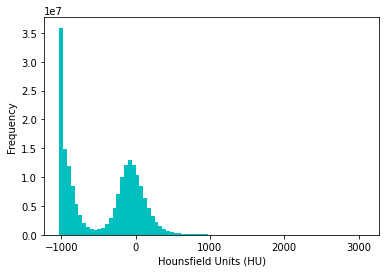

In [4]:
from matplotlib import pyplot as plt

img, origin, spacing = load_itk(file_list[0])
first_patient_pixels = img
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Resample all images to isomorphic spacing

Since CT Scans have different spacings between voxels, which is because of that the different devices have different configurations, so we unify all of the 3d images spacings into isomorphic form of 1mm in each axis (or saggital, coronal, and axial plane).

In [5]:
def resample(image, previous_spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(previous_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [6]:
img2, spacing2 = resample(img, spacing)

In [7]:
print(img.shape, spacing)
print(img2.shape, spacing2)

(733, 512, 512) [0.5        0.63671875 0.63671875]
(366, 326, 326) [1.00136612 1.         1.        ]


So, as you see the image shapes have been changed as well.

# Removing other body organs from image

At the next step we would like to clean up the 3d array of CT Scan, because we like to tell our neural network to pay attention to really important parts, and not to get lost looking at a large amount of unnecessary information.

To reach this, we will go through these steps:
1. Convert the original 3d image into a binary image.
2. Remove the blobs connected to the border of the image.
3. Label the connected points of the image.
4. Keep the labels with 2 largest areas and segment two lungs.
5. Fill in the small holes inside the mask of lungs which we seperate right and left lung.
6. Fill convex hull of each lung.
7. Joint two separated right and left lungs.
8. Closure operation with a disk of radius 10. This operation is to keep nodules attached to the lung wall.
9. Superimpose the binary mask on the input image.


In summary, we segment lungs and make a mask from them, then throw away the voxels out of that mask at the original image.
(I have tried these steps to be similar to ones at [the paper of grt123 team](https://arxiv.org/abs/1711.08324), part <i>B. Preprocessing</i>)


In [8]:
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    plt_number = 0
    # Original image label: 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    # Step 1: Convert into a binary image.
    # image label: 1
    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 2: Remove the blobs connected to the border of the image.
    # image label: 2
    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
    # Step 3: Label the image.
    # image label: 3
    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1

    # Step 4: Keep the labels with 2 largest areas and segment two lungs.
    # image label: 4
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!
    # image labels: 5, 6
    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1

    # Step 6: convex hull of each lung
    # image labels: 7, 8
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
    # Step 7: joint two separated right and left lungs.
    # image label: 9
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 8: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    # image label: 10
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 9: Superimpose the binary mask on the input image.
    # image label: 11
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    return im

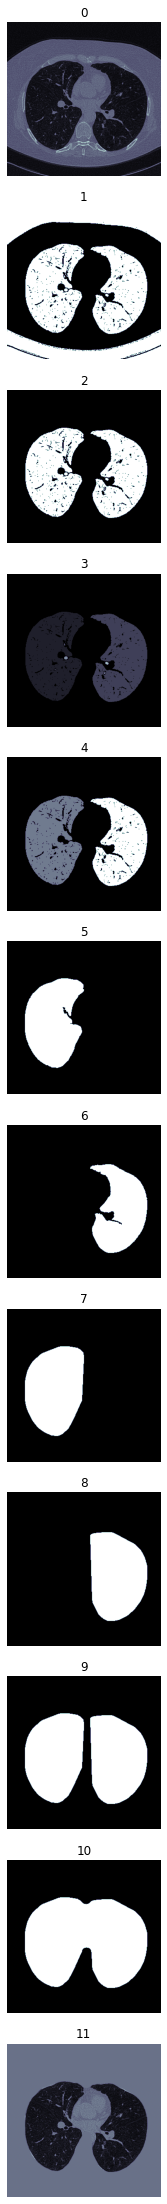

In [9]:
from matplotlib import pyplot as plt
tmp_2d_img = get_segmented_lungs(img2[200,:,:], True)

In [10]:
img3 = np.asarray([get_segmented_lungs(im) for im in img2])

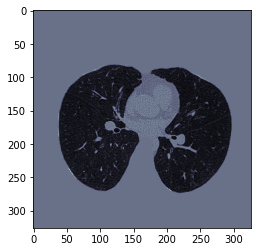

In [11]:
from matplotlib import pyplot as plt
plt.imshow(img3[201,:,:], cmap=plt.cm.bone)
plt.show()


Compared to first image which was:

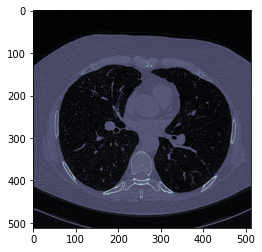

In [12]:
from matplotlib import pyplot as plt
plt.imshow(first_patient_pixels[int(201*733/366),:,:], cmap=plt.cm.bone)
plt.show()

Well done!

Now lets go furtur to the next step of preprocessing.

# Normalizing the image

It is pretty simple, we make a bounding on voxel values to be inside [-1200.0, 600.0] and if it was out of the bounding, it would be decreased or increased to be equal to 600 or -1200.

Then we will scale values to be inside [0.0, 255.0].


In [13]:
def normalize(image):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image2[image2 > 1] = 1.
        image2[image2 < 0] = 0.
        image2 *= 255.
        return image2

In [14]:
img4 = normalize(img3)

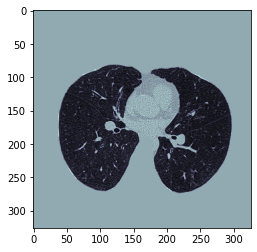

In [15]:
plt.imshow(img4[201,:,:], cmap=plt.cm.bone)
plt.show()

Then we will zero center images. But it is not per image, it is based on mean of whole dataset.

After some searches, I found out that mean value of Luna16 is almost 0.25 (before scaling to [0.0, 255.0]).

**Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.**

In [16]:
def zero_center(image):
    PIXEL_MEAN = 0.25 * 256
    image2 = image - PIXEL_MEAN
    return image2

In [17]:
img5 = zero_center(img4)

In [ ]:
plt.imshow(img5[200,:,:], cmap=plt.cm.bone)
plt.show()

# The End

We have covered almost all of the preprocessing steps of [the paper of grt123 team](https://arxiv.org/abs/1711.08324) and `preprocess` method of [CTScan class](https://github.com/s-mostafa-a/Luna16/blob/master/preprocess/_ct_scan.py).